# Recurrent Neural Network (LSTM)
We use a Long Short Term Memory (LSTM) network to make predictions.
Resources:
https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f

In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Activation
import time
import csv
from sklearn.metrics import mean_squared_error

## 1) Pure sin wave

Our goal is to predict a time series using an LSTM. We will start, as a proof of concept, with a perfect sine wave. If the network is functioning, it should be able to predict this with nearly 100% accuracy.

(0, 0.1)

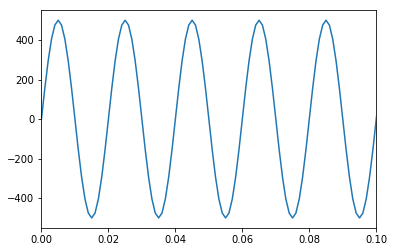

In [254]:
df = pd.read_csv('./data/50Hzsinwave.csv',header=None)
dataset = df.values

dataset[:,1] = dataset[:,1]*500
plt.plot(dataset[:,0],dataset[:,1])
plt.xlim(0,0.1)

Use the series_to_supervised function to transform the time series into a supervised learning problem.

In [256]:
from utils import series_to_supervised

num_predict = 10
# n_in is the number of samples for "input" and n_out is the number for "output", or prediction
supervised_dataset = series_to_supervised(dataset[:,1:2],n_in=50,n_out=num_predict)
sup_ds = supervised_dataset.values

The data will typically need to be scaled. Here, we perform mean normalization to scale the data.

In [258]:
row_mean = sup_ds.mean(axis=1,keepdims=True)
row_max = sup_ds.max(axis=1,keepdims=True)
row_min = sup_ds.min(axis=1,keepdims=True)

scl_sup_ds = (sup_ds-row_mean)/(row_max-row_min)

Now we just need to split the scaled dataset into training and testing.

In [259]:
N_train = int(0.8*np.size(scl_sup_ds,0))

scaled_train = scl_sup_ds[0:N_train,:]
scaled_test = scl_sup_ds[N_train:,:]

Now we will define the model.

In [260]:
def fit_lstm(train, n_lag, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:-n_lag], train[:, -n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # define parameters
    verbose, epochs, batch_size = 1, nb_epoch, n_batch
    n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
    # design network
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model
    
model_lstm = fit_lstm(scaled_train, num_predict, 10, 5, 300)
model_lstm.summary()

Epoch 1/5
752/752 [==============================] - 1s - loss: 0.0200     
Epoch 2/5
752/752 [==============================] - 0s - loss: 2.3028e-05     
Epoch 3/5
752/752 [==============================] - 0s - loss: 4.8295e-06     
Epoch 4/5
752/752 [==============================] - 0s - loss: 2.4803e-06     
Epoch 5/5
752/752 [==============================] - 0s - loss: 1.4935e-06     
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 200)               200800    
_________________________________________________________________
dense_22 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                1010      
Total params: 221,910.0
Trainable params: 221,910
Non-trainable params: 0.0
_________________________________________________________________


In [261]:
# Make one forecast
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return forecast

def make_forecasts(model, n_batch, test, n_lag):
    forecasts = np.zeros((test.shape[0],n_lag))
    for i in range(test.shape[0]):
        X, y = test[i, 0:-n_lag], test[i, -n_lag:]
        # make forecast
        forecasts[i,:] = forecast_lstm(model, X, n_batch)
    return forecasts

scaled_forecasts = make_forecasts(model_lstm, 1, scaled_test, num_predict)

(189, 10) (189, 60)
rmse for (LSTM) testing:  [0.00116888 0.00098817 0.00150102 0.00075067 0.0010543  0.00121683
 0.0015194  0.00107497 0.0008658  0.00092364]
rmse for (persistence) testing:  [0.11033721 0.21803985 0.32052019 0.41528702 0.5        0.57252888
 0.63101569 0.67393629 0.70015611 0.70897497]


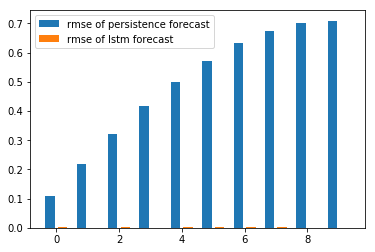

In [262]:
y_pers_test = np.transpose(np.tile(scaled_test[:,-num_predict-1], (num_predict,1)))

print(scaled_forecasts.shape,scaled_test.shape)

rmse_lstm_test = np.sqrt(np.mean((scaled_forecasts-scaled_test[:,-10:])**2,axis=0))
print("rmse for (LSTM) testing: ", rmse_lstm_test)

rmse_pers_test = np.sqrt(np.mean((y_pers_test-scaled_test[:,-10:])**2,axis=0))
print("rmse for (persistence) testing: ", rmse_pers_test)

plt.figure()
plt.bar(np.arange(0,num_predict)-0.2,rmse_pers_test,0.3,label='rmse of persistence forecast')
plt.bar(np.arange(0,num_predict)+0.2,rmse_lstm_test,0.3,label='rmse of lstm forecast')
plt.legend()

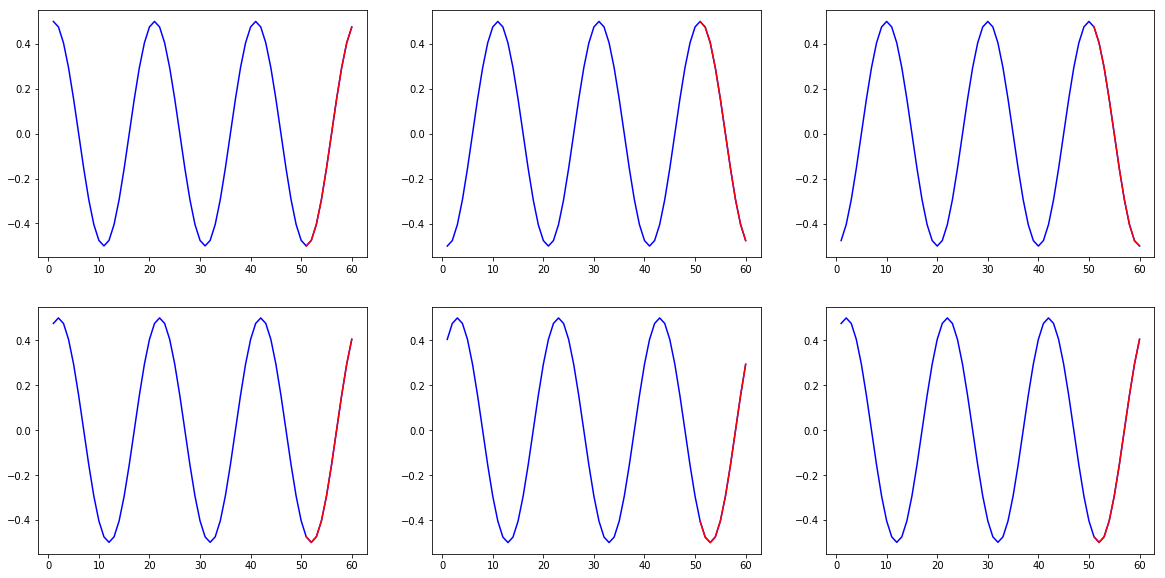

In [263]:
#look at a random sample to see how we did

num_lookback = 50
num_predict = 10
chunk_size = num_lookback + num_predict

plt.figure(figsize=(20,10))
for i in np.arange(1,7):
    sample = np.random.randint(0,scaled_forecasts.shape[0])
    plt.subplot(2,3,i)
    plt.plot(np.linspace(1,chunk_size,num=chunk_size),scl_sup_ds[sample+N_train,:],color='blue')
    plt.plot(np.linspace(num_lookback+1,chunk_size,num=num_predict),scaled_forecasts[sample,:],color='red')

## 2) Noisy sin wave
The network did well with the sin wave, as it should. Let's add some noise to the sin wave and see how it does.

In [264]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense, Activation
import time
import csv
from sklearn.metrics import mean_squared_error

np.random.seed(1234)

(0, 0.2)

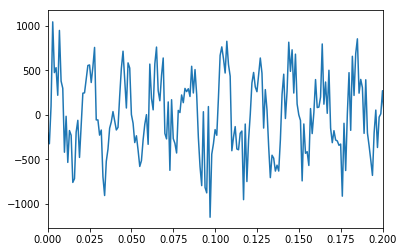

In [266]:
df = pd.read_csv('./data/50Hzsinwave.csv',header=None)
dataset = df.values
dataset[:,1] = dataset[:,1]*500 # Put it in LFP scale

# Make noise vector with different levels of noise
noise = np.zeros((dataset.shape[0],5))
noise[:,0:1] = 50*np.random.randn(1,dataset.shape[0]).T
noise[:,1:2] = 100*np.random.randn(1,dataset.shape[0]).T
noise[:,2:3] = 150*np.random.randn(1,dataset.shape[0]).T
noise[:,3:4] = 200*np.random.randn(1,dataset.shape[0]).T
noise[:,4:5] = 250*np.random.randn(1,dataset.shape[0]).T

dataset[:,1] = dataset[:,1] + noise[:,4]


plt.plot(dataset[:,0],dataset[:,1])
plt.xlim(0,0.2)

Epoch 1/20
752/752 [==============================] - 2s - loss: 0.0303     
Epoch 2/20
752/752 [==============================] - 0s - loss: 0.0213     
Epoch 3/20
752/752 [==============================] - 0s - loss: 0.0205     
Epoch 4/20
752/752 [==============================] - 0s - loss: 0.0199     
Epoch 5/20
752/752 [==============================] - 0s - loss: 0.0194     
Epoch 6/20
752/752 [==============================] - 0s - loss: 0.0188     
Epoch 7/20
752/752 [==============================] - 0s - loss: 0.0182     
Epoch 8/20
752/752 [==============================] - 0s - loss: 0.0177     
Epoch 9/20
752/752 [==============================] - 1s - loss: 0.0172     
Epoch 10/20
752/752 [==============================] - ETA: 0s - loss: 0.016 - 0s - loss: 0.0167     
Epoch 11/20
752/752 [==============================] - 0s - loss: 0.0163     
Epoch 12/20
752/752 [==============================] - 0s - loss: 0.0159     
Epoch 13/20
752/752 [============================

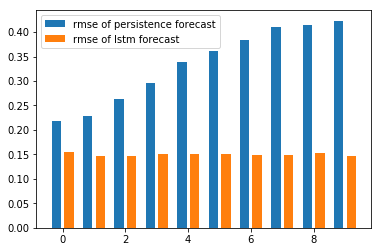

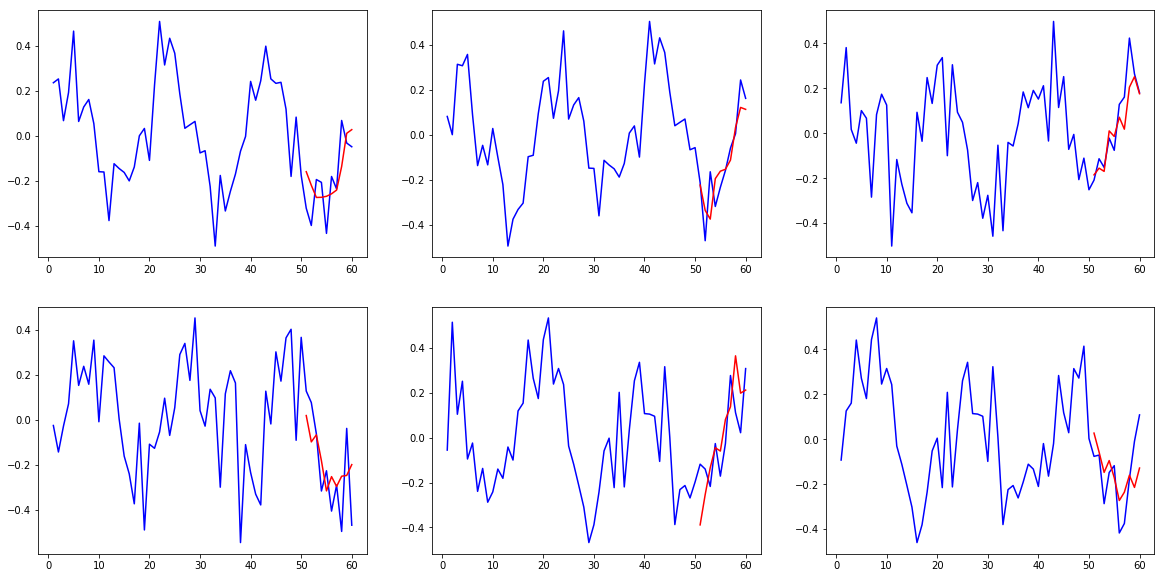

In [269]:
from utils import series_to_supervised

# Series to supervised
num_predict = 10
# n_in is the number of samples for "input" and n_out is the number for "output", or prediction
supervised_dataset = series_to_supervised(dataset[:,1:2],n_in=50,n_out=num_predict)
sup_ds = supervised_dataset.values

# Scale
row_mean = sup_ds.mean(axis=1,keepdims=True)
row_max = sup_ds.max(axis=1,keepdims=True)
row_min = sup_ds.min(axis=1,keepdims=True)

scl_sup_ds = (sup_ds-row_mean)/(row_max-row_min)

# Train test split
N_train = int(0.8*np.size(scl_sup_ds,0))

scaled_train = scl_sup_ds[0:N_train,:]
scaled_test = scl_sup_ds[N_train:,:]

# train
def fit_lstm(train, n_lag, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:-n_lag], train[:, -n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    # define parameters
    verbose, epochs, batch_size = 1, nb_epoch, n_batch
    n_timesteps, n_features, n_outputs = X.shape[1], X.shape[2], y.shape[1]
    # design network
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model
    
model_lstm = fit_lstm(scaled_train, num_predict, 10, 20, 300)
model_lstm.summary()

# Make one forecast
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return forecast

def make_forecasts(model, n_batch, test, n_lag):
    forecasts = np.zeros((test.shape[0],n_lag))
    for i in range(test.shape[0]):
        X, y = test[i, 0:-n_lag], test[i, -n_lag:]
        # make forecast
        forecasts[i,:] = forecast_lstm(model, X, n_batch)
    return forecasts

scaled_forecasts = make_forecasts(model_lstm, 1, scaled_test, num_predict)

y_pers_test = np.transpose(np.tile(scaled_test[:,-num_predict-1], (num_predict,1)))

print(scaled_forecasts.shape,scaled_test.shape)

rmse_lstm_test = np.sqrt(np.mean((scaled_forecasts-scaled_test[:,-10:])**2,axis=0))
print("rmse for (LSTM) testing: ", rmse_lstm_test)

rmse_pers_test = np.sqrt(np.mean((y_pers_test-scaled_test[:,-10:])**2,axis=0))
print("rmse for (persistence) testing: ", rmse_pers_test)

plt.figure()
plt.bar(np.arange(0,num_predict)-0.2,rmse_pers_test,0.3,label='rmse of persistence forecast')
plt.bar(np.arange(0,num_predict)+0.2,rmse_lstm_test,0.3,label='rmse of lstm forecast')
plt.legend()

#look at a random sample to see how we did

num_lookback = 50
num_predict = 10
chunk_size = num_lookback + num_predict

plt.figure(figsize=(20,10))
for i in np.arange(1,7):
    sample = np.random.randint(0,scaled_forecasts.shape[0])
    plt.subplot(2,3,i)
    plt.plot(np.linspace(1,chunk_size,num=chunk_size),scl_sup_ds[sample+N_train,:],color='blue')
    plt.plot(np.linspace(num_lookback+1,chunk_size,num=num_predict),scaled_forecasts[sample,:],color='red')